# StackingGCN

Este notebook tem como objetivo apresentar a proposta do *StackingGCN*, um classificador *stacking* utilizando como *meta-learner* uma *Graph Convolutional Network* (GCN).

# Instalando e Importando Bibliotecas


In [422]:
!pip install scikit-network
from IPython.display import SVG, display

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.datasets import fetch_openml, load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.preprocessing import normalize
from sklearn.svm import SVC

from sknetwork.gnn import GNNClassifier
from sknetwork.visualization import svg_graph

import matplotlib.pyplot as plt
import numpy as np
import warnings

# GCN Classifier

In [401]:
## Classe que faz a adaptação do GNNClassifier para o stacking
class GCNClassifier(BaseEstimator, ClassifierMixin):

    ## Inicializa o classificador
    ## Parâmetros:
    ## - dims: Dimensionamento das camadas ocultas do GCN
    ## - n_epochs: Quantidade de épocas para a rede neural
    ## - n_neighbors: Quantidade de nós vizinhos por nó na criação do grafo (Levando em conta o próprio nó)
    ## - train_data: Dados de treino
    ## - test_data: Dados de teste
    ## - features_like_dataset: Faz com que as features do grafo sejam apenas as próprias features do dataset
    ## - features_by_results: Faz com que as features do grafo sejam apenas o resultado do stacking se True, caso contrário, é feita uma concatenação das features do dataset com o resultado do stacking
    ##                        (Válido apenas quando features_like_dataset = False)
    ## - mode: Modo de conexão para o kneighbors_graph
    ## - random_state: Seed para as operações
    ## - verbose: Caso queira ou não a visualização das epochs ao longo da execução da rede neural
    def __init__(self, dims, n_epochs=100, n_neighbors=3, train_data=[], test_data=[], features_like_dataset=False, features_by_results=True, mode='connectivity', random_state=42, verbose=True):
        self.train_data = train_data
        self.test_data = test_data

        self.features_like_dataset = features_like_dataset
        self.features_by_results = features_by_results
        self.n_neighbors = n_neighbors
        self.mode = mode

        self.random_state = random_state
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.dims = dims

    ## Mock para um falso treino do dataset, neste cenário, apenas guardando o conjunto de treinamento
    def fit(self, X, y=None):
        self.x_train = X
        self.y_train = y

    ## Realiza a construção do grafo e o próprio treino e teste do dataset
    def predict(self, X, y=None):
        y_all = np.concatenate((self.y_train, np.full(X.shape[0], -1)), axis=0)

        data_features = np.concatenate((self.train_data, self.test_data), axis=0)
        model_features = np.concatenate((self.x_train, X), axis=0)

        graph_connectors = data_features

        knGraph = kneighbors_graph(graph_connectors, self.n_neighbors, mode=self.mode)
        nodes_features = None

        if self.features_like_dataset:
            nodes_features = data_features
        elif self.features_by_results:
            nodes_features = model_features
        else:
            nodes_features = np.concatenate((data_features, model_features), axis=1)

        gnn = GNNClassifier(dims=self.dims,
                            layer_types='Conv',
                            activations='ReLu',
                            verbose=self.verbose)

        gnn_predict = gnn.fit_predict(knGraph, nodes_features, y_all, n_epochs=self.n_epochs, random_state=self.random_state)

        return gnn_predict[self.x_train.shape[0] : ].astype(int)

# Dataset Run

In [311]:
## Método auxiliar para visualização da contagem de elementos por classe
def count_elements(array):
    unique_values, counts = np.unique(array, return_counts=True)

    # Imprime os resultados
    for value, count in zip(unique_values, counts):
        print(f"{value} --> {count}")

    return unique_values

In [454]:
## Classe DatasetRun, responsável pela execução do dataset
class DatasetRun():
    data = []
    target = []
    n_labels = 2

    ## Inicialização da classe
    ## Parâmetros:
    ## - data: A matriz representando as features de cada elemento do dataset
    ## - target: A lista representando as classes de cada elemento do dataset
    def __init__(self, data, target):
        self.data = normalize(data, axis=0)
        self.target = target

        unique_values = count_elements(target)
        self.n_labels = unique_values.shape[0]


    ## Divisão do dataset em treino e teste
    ## Parâmetros:
    ## - test_size: Porcentagem que indica a proporção do conjunto voltada para o teste
    ## - to_be_stratified: Indica se o dataset deve ser separado de forma estratificada de acordo com as proporções entre as classes
    def split(self, test_size, to_be_stratified=False):
        stratify = None
        if to_be_stratified:
            stratify = self.target

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.data, self.target, test_size=test_size, random_state=42, stratify=stratify, shuffle=True)
        count_elements(array=self.y_train)


    ## Execução dos classificadores base individualmente para determinar os parâmetros e, uma vez determinados, as acurácias
    ## Parâmetros:
    ## - n_folds: Quantidade de divisões para o cross-validation
    ## - print_parameters: Indica se deve ser printado os parâmetros selecionados
    def run_base_estimators(self, n_folds=5, print_parameters=False):
        self.__train_estimators_parameters(n_folds, print_parameters)

        estimatorsArray = self.__doEstimatorsArray()

        for estimator in estimatorsArray:
            ml_method = estimator[1]
            ml_method.fit(self.x_train, self.y_train)
            accuracy = ml_method.score(self.x_test, self.y_test)
            print('Acurácia do método %s = %.4f\n' % (estimator[0], accuracy))

    ## Execução do stacking padrão (com LogisticRegression)
    def run_sc_lr(self):
        sc_lr = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=LogisticRegression(max_iter=500))
        sc_lr.fit(self.x_train, self.y_train)

        accuracy = sc_lr.score(self.x_test, self.y_test)
        print('Acurácia do StackingClassifier padrão (com Logistic Regression): %.4f' % accuracy)

    ## Execução dos StackingGCNs
    ## Parâmetros:
    ## - n_epochs: Quantidade de épocas para a rede neural
    ## - dims: Dimensionamento das camadas ocultas do GCN
    ## - verbose: Caso queira ou não a visualização das epochs ao longo da execução da rede neural
    ## - n_ct: Quantidade de nós vizinhos por nó na criação do grafo (Levando em conta o próprio nó)
    def run_sc_gcn(self, n_epochs, dims=[], verbose=True, n_ct=5):
        dims.append(self.n_labels)

        gcnCustom0 = GCNClassifier(dims=dims,n_epochs=n_epochs,random_state=42,n_neighbors=n_ct,features_like_dataset=True, train_data=self.x_train,test_data=self.x_test,verbose=verbose)

        sc_gcn0 = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnCustom0)
        sc_gcn0.fit(self.x_train, self.y_train)

        print('Acurácia do StackingGCN (Features = dataset): %.4f' % sc_gcn0.score(self.x_test, self.y_test))

        ######### STACKING CLASSIFIER WITH GCN (FEATURES = STACKING RESULTS)
        gcnCustom = GCNClassifier(dims=dims,n_epochs=n_epochs,random_state=42,n_neighbors=n_ct,train_data=self.x_train,test_data=self.x_test,verbose=verbose)

        sc_gcn = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnCustom)
        sc_gcn.fit(self.x_train, self.y_train)

        print('Acurácia do StackingGCN (Features = stacking results): %.4f' % sc_gcn.score(self.x_test, self.y_test))

        ######### STACKING CLASSIFIER WITH GCN (FEATURES = DATASET + STACKING RESULTS)
        gcnCustom2 = GCNClassifier(dims=dims,n_epochs=n_epochs,random_state=42,n_neighbors=n_ct,features_by_results=False,train_data=self.x_train,test_data=self.x_test,verbose=verbose)

        sc_gcn2 = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnCustom2)
        sc_gcn2.fit(self.x_train, self.y_train)

        print('Acurácia do StackingGCN (Features = dataset + stacking results): %.4f' % sc_gcn2.score(self.x_test, self.y_test))


    ## Execução do stacking padrão e do stackingGCN para obtenção das métricas e das matrizes de confusão
    ## Parâmetros:
    ## - n_epochs: Quantidade de épocas para a rede neural
    ## - dims: Dimensionamento das camadas ocultas do GCN
    ## - n_ct: Quantidade de nós vizinhos por nó na criação do grafo (Levando em conta o próprio nó)
    ## - features_like_dataset: Faz com que as features do grafo sejam apenas as próprias features do dataset
    ## - features_by_results: Faz com que as features do grafo sejam apenas o resultado do stacking se True, caso contrário, é feita uma concatenação das features do dataset com o resultado do stacking
    ##                        (Válido apenas quando features_like_dataset = False)
    def get_classification_report(self, n_epochs, dims=[], n_ct=5, features_like_dataset=False, features_by_results=True):
        sc_lr = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=LogisticRegression(max_iter=500))
        sc_lr.fit(self.x_train, self.y_train)
        lr_pred = sc_lr.predict(self.x_test)

        print(classification_report(self.y_test, lr_pred, digits=4))

        plt.figure()
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.y_test, lr_pred)).plot()
        plt.grid(False)
        plt.show()

        dims.append(self.n_labels)
        gcnClassifier = GCNClassifier(dims=dims, n_epochs=n_epochs, random_state=42,n_neighbors=n_ct,features_like_dataset=features_like_dataset, features_by_results=features_by_results, train_data=self.x_train,test_data=self.x_test,verbose=False)
        sc_gcn = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnClassifier)
        sc_gcn.fit(self.x_train, self.y_train)
        gcn_pred = sc_gcn.predict(self.x_test)

        print(classification_report(self.y_test, gcn_pred, digits=4))

        plt.figure()
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.y_test, gcn_pred)).plot()
        plt.grid(False)
        plt.show()


    ## Execução do stackingGCN para geração do grafo com o vetor de classes que foi resultado da classificação
    ## Parâmetros:
    ## - n_epochs: Quantidade de épocas para a rede neural
    ## - dims: Dimensionamento das camadas ocultas do GCN
    ## - n_ct: Quantidade de nós vizinhos por nó na criação do grafo (Levando em conta o próprio nó)
    ## - mode: Modo de conexão para o kneighbors_graph
    ## - features_like_dataset: Faz com que as features do grafo sejam apenas as próprias features do dataset
    ## - features_by_results: Faz com que as features do grafo sejam apenas o resultado do stacking se True, caso contrário, é feita uma concatenação das features do dataset com o resultado do stacking
    ##                        (Válido apenas quando features_like_dataset = False)
    def visualize_graph(self, n_epochs, dims=[], n_ct=5, mode='connectivity', features_like_dataset=False, features_by_results=True):
        full_data = np.concatenate((self.x_train, self.x_test), axis=0)
        adj_graph = kneighbors_graph(full_data, n_ct, mode=mode)


        sc_gcn = dims.append(self.n_labels)
        gcnClassifier = GCNClassifier(dims=dims, n_epochs=n_epochs, random_state=42,n_neighbors=n_ct,features_like_dataset=features_like_dataset, features_by_results=features_by_results, train_data=self.x_train,test_data=self.x_test,verbose=False)
        sc_gcn = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnClassifier)
        sc_gcn.fit(self.x_train, self.y_train)
        gcn_pred = sc_gcn.predict(self.x_test)

        pred_labels = np.concatenate((self.y_train, gcn_pred), axis=0)
        predict_graph = svg_graph(adj_graph, labels=pred_labels, width=600, height=450)

        display(SVG(predict_graph))


    #####################################################################################################################################################
    #### Métodos auxiliares

    ## Auxiliar para a execução do cross-validation do classificador SVM
    ## - svc: Classificador SVM
    ## - kf: K-Fold
    def __runSVC(self, svc, kf):
        scores = cross_val_score(svc, self.x_train, self.y_train, cv=kf)
        return scores.mean(), scores.std()


    ## Realização do cross validation para cada classificador obtendo a melhor combinação de parâmetros
    ## Parâmetros:
    ## - n_folds: Quantidade de divisões para o cross-validation
    ## - print_parameters: Indica se deve ser printado os parâmetros selecionados
    def __train_estimators_parameters(self, n_folds, print_parameters):
        ## Cross val score para obtenção dos melhores parâmetros para os estimadores base
        kf = KFold(n_splits=n_folds)

        kArray = [1,3,5,7]
        bestMean = 0
        bestStd = float('inf')
        for k in kArray:
            scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), self.x_train, self.y_train, cv=kf)
            mean = scores.mean()
            std = scores.std()

            if (mean > bestMean) or (mean == bestMean and std < bestStd):
                self.k = k
                bestMean = mean
                bestStd = std

        if print_parameters:
            print('Acurácia com K-NN %d: %0.4f +/- %0.4f' % (self.k, bestMean, bestStd))

        nArray = [10,25,50,100]
        bestMean = 0
        bestStd = float('inf')
        for n in nArray:
            scores = cross_val_score(RandomForestClassifier(n_estimators=n, random_state=42), self.x_train, self.y_train, cv=kf)
            mean = scores.mean()
            std = scores.std()

            if (mean > bestMean) or (mean == bestMean and std < bestStd):
                self.n = n
                bestMean = mean
                bestStd = std

        if print_parameters:
            print('Acurácia com Random Forest %d-estimators: %0.4f +/- %0.4f' % (self.n, bestMean, bestStd))

        kernelArray = ['linear', 'poly', 'rbf', 'sigmoid']
        gammaArray = ['scale', 'auto']
        degreeArray = [3,4,5]

        self.gamma = 'scale'
        self.degree = 3
        bestMean = 0
        bestStd = float('inf')

        for kernel in kernelArray:
            if kernel == 'linear':
                mean, std = self.__runSVC(SVC(kernel='linear'), kf)

                if (mean > bestMean) or (mean == bestMean and std < bestStd):
                    self.kernel = 'linear'
                    bestMean = mean
                    bestStd = std

            else:
                for gamma in gammaArray:
                    if kernel == 'poly':
                        for degree in degreeArray:
                            mean, std = self.__runSVC(SVC(kernel=kernel, gamma=gamma, degree=degree), kf)

                            if (mean > bestMean) or (mean == bestMean and std < bestStd):
                                self.kernel = 'poly'
                                self.gamma = gamma
                                self.degree = degree
                                bestMean = mean
                                bestStd = std
                    else:
                        mean, std = self.__runSVC(SVC(kernel=kernel, gamma=gamma), kf)

                        if (mean > bestMean) or (mean == bestMean and std < bestStd):
                            self.kernel = kernel
                            self.gamma = gamma
                            bestMean = mean
                            bestStd = std

        if print_parameters:
            print('Acurácia com SVC com kernel %s, gamma %s e degree %d: %0.4f +/- %0.4f' % (self.kernel, self.gamma, self.degree, bestMean, bestStd))

    ## Criação do vetor com os classificadores base
    ## Parâmetros:
    ## - random_state: Seed para as operações
    def __doEstimatorsArray(self, random_state=42):
        return [('knn', KNeighborsClassifier(n_neighbors=self.k)),
                ('rf', RandomForestClassifier(n_estimators=self.n, random_state=random_state)),
                ('svc', SVC(kernel=self.kernel, gamma=self.gamma, degree=self.degree))]

# TESTES

Em cada uma das subseções abaixo, é realizado o fluxo de classificação por meio da classe *DatasetRun* para cada dataset.

## Dataset Iris

### Inicialização do dataset

In [411]:
iris_dataset = load_iris()
dt_iris = DatasetRun(iris_dataset.data, iris_dataset.target)

0 --> 50
1 --> 50
2 --> 50


### Divisão em treino e teste

In [412]:
dt_iris.split(test_size=0.9, to_be_stratified=True)

0 --> 5
1 --> 5
2 --> 5


### Execução dos classificadores base

In [413]:
dt_iris.run_base_estimators()

Acurácia do método knn = 0.9704

Acurácia do método rf = 0.9556

Acurácia do método svc = 0.9556



### Execução do *Stacking* padrão

In [414]:
dt_iris.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.9630


### Execução do *StackingGCN*

In [415]:
dt_iris.run_sc_gcn(n_epochs=100, verbose=False, dims=[9])

Acurácia do StackingGCN (Features = dataset): 0.9630
Acurácia do StackingGCN (Features = stacking results): 0.9556
Acurácia do StackingGCN (Features = dataset + stacking results): 0.9704


## Dataset Digits

### Inicialização do dataset

In [430]:
digits_dataset = load_digits()
dt_digits = DatasetRun(digits_dataset.data, digits_dataset.target)

0 --> 178
1 --> 182
2 --> 177
3 --> 183
4 --> 181
5 --> 182
6 --> 181
7 --> 179
8 --> 174
9 --> 180


### Divisão em treino e teste

In [431]:
dt_digits.split(test_size=0.97, to_be_stratified=True)

0 --> 5
1 --> 6
2 --> 5
3 --> 6
4 --> 5
5 --> 6
6 --> 5
7 --> 5
8 --> 5
9 --> 5


### Execução dos classificadores base

In [432]:
dt_digits.run_base_estimators()

Acurácia do método knn = 0.7718

Acurácia do método rf = 0.7861

Acurácia do método svc = 0.7878



### Execução do *Stacking* padrão

In [433]:
dt_digits.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.7110


### Execução do *StackingGCN*

In [434]:
dt_digits.run_sc_gcn(n_epochs=200, verbose=False, dims=[30])

Acurácia do StackingGCN (Features = dataset): 0.8440
Acurácia do StackingGCN (Features = stacking results): 0.8217
Acurácia do StackingGCN (Features = dataset + stacking results): 0.8131


## Dataset Wine

### Inicialização do dataset

In [455]:
wine_dataset = load_wine()
dt_wine = DatasetRun(wine_dataset.data, wine_dataset.target)

0 --> 59
1 --> 71
2 --> 48


### Divisão em treino e teste

In [456]:
dt_wine.split(test_size=0.89, to_be_stratified=True)

0 --> 6
1 --> 8
2 --> 5


### Execução dos classificadores base

In [457]:
dt_wine.run_base_estimators()

Acurácia do método knn = 0.9497

Acurácia do método rf = 0.9748

Acurácia do método svc = 0.9560



### Execução do *Stacking* padrão

In [458]:
dt_wine.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.9623


### Execução do *StackingGCN*

In [459]:
dt_wine.run_sc_gcn(n_epochs=200, verbose=False, dims=[9])

Acurácia do StackingGCN (Features = dataset): 0.8365
Acurácia do StackingGCN (Features = stacking results): 0.9686
Acurácia do StackingGCN (Features = dataset + stacking results): 0.9623


## Dataset Breast Cancer

### Inicialização do dataset

In [357]:
bc_dataset = load_breast_cancer()
dt_bc = DatasetRun(bc_dataset.data, bc_dataset.target)

0 --> 212
1 --> 357


### Divisão em treino e teste

In [358]:
dt_bc.split(test_size=0.97, to_be_stratified=True)

0 --> 6
1 --> 11


### Execução dos classificadores base

In [359]:
dt_bc.run_base_estimators()

Acurácia do método knn = 0.9022

Acurácia do método rf = 0.8913

Acurácia do método svc = 0.9058



### Execução do *Stacking* padrão

In [360]:
dt_bc.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.8551


### Execução do *StackingGCN*

In [361]:
dt_bc.run_sc_gcn(n_epochs=300, verbose=False, dims=[6])

Acurácia do StackingGCN (Features = dataset): 0.8895
Acurácia do StackingGCN (Features = stacking results): 0.9203
Acurácia do StackingGCN (Features = dataset + stacking results): 0.9149


## Dataset QSAR

### Inicialização do dataset

In [438]:
qsar = fetch_openml(name='qsar-biodeg', parser = 'auto')

dt_qsar = DatasetRun(qsar.data, qsar.target)

1 --> 699
2 --> 356


### Divisão em treino e teste

In [439]:
dt_qsar.split(test_size=0.98, to_be_stratified=True)

1 --> 14
2 --> 7


### Execução dos classificadores base

In [440]:
dt_qsar.run_base_estimators()

Acurácia do método knn = 0.7253

Acurácia do método rf = 0.7234

Acurácia do método svc = 0.6625



### Execução do *Stacking* padrão

In [441]:
dt_qsar.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.6625


### Execução do *StackingGCN*

In [442]:
dt_qsar.run_sc_gcn(n_epochs=200, verbose=False, dims=[6])

Acurácia do StackingGCN (Features = dataset): 0.6992
Acurácia do StackingGCN (Features = stacking results): 0.7369
Acurácia do StackingGCN (Features = dataset + stacking results): 0.7002


## Análise do melhor dataset

### Geração das métricas e das matrizes de confusão para o melhor dataset

              precision    recall  f1-score   support

           0     0.9422    0.9422    0.9422       173
           1     0.5070    0.8239    0.6277       176
           2     0.6143    0.5000    0.5513       172
           3     0.6140    0.7910    0.6914       177
           4     0.9861    0.8068    0.8875       176
           5     0.7658    0.6875    0.7246       176
           6     0.8656    0.9148    0.8895       176
           7     0.9112    0.8851    0.8980       174
           8     0.3357    0.2840    0.3077       169
           9     0.6838    0.4571    0.5479       175

    accuracy                         0.7110      1744
   macro avg     0.7226    0.7092    0.7068      1744
weighted avg     0.7237    0.7110    0.7082      1744



<Figure size 640x480 with 0 Axes>

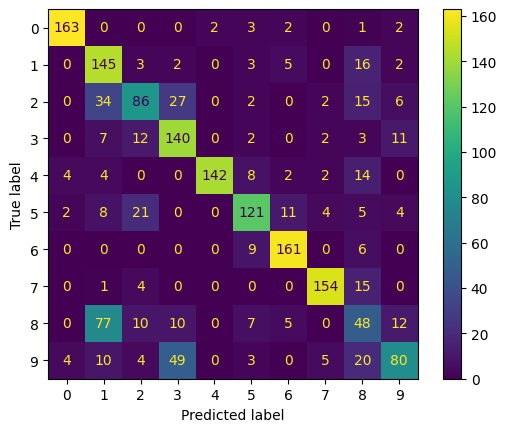

              precision    recall  f1-score   support

           0     1.0000    0.9827    0.9913       173
           1     0.7120    0.7727    0.7411       176
           2     0.7582    0.8023    0.7797       172
           3     0.7259    0.8079    0.7647       177
           4     0.9938    0.9034    0.9464       176
           5     0.9167    0.8750    0.8953       176
           6     0.9831    0.9886    0.9858       176
           7     0.9600    0.8276    0.8889       174
           8     0.4555    0.5148    0.4833       169
           9     0.8101    0.7314    0.7688       175

    accuracy                         0.8217      1744
   macro avg     0.8315    0.8206    0.8245      1744
weighted avg     0.8327    0.8217    0.8256      1744



<Figure size 640x480 with 0 Axes>

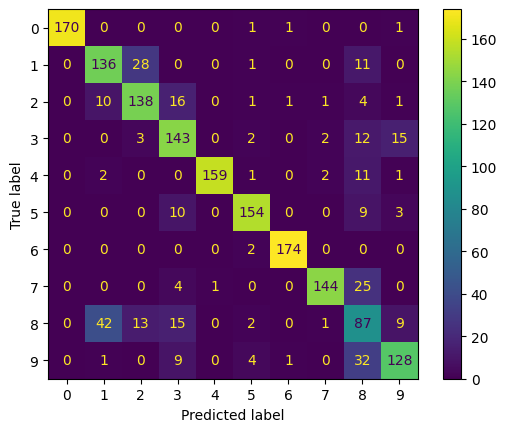

In [399]:
dt_digits.get_classification_report(200, dims=[30])

### Visualização de um grafo

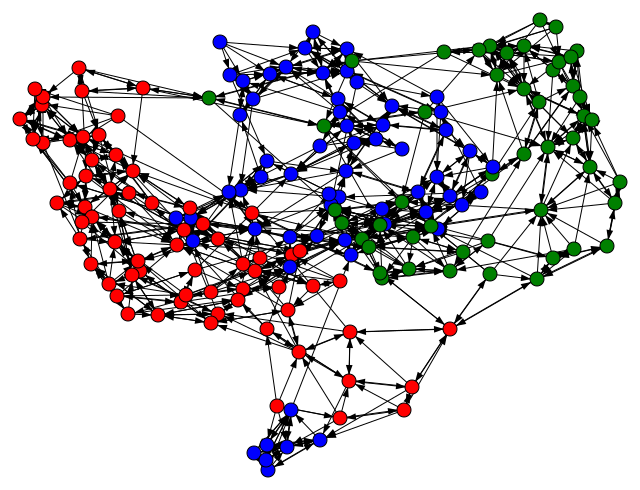

In [460]:
dt_wine.visualize_graph(200, dims=[9])